#Necessary libraries 

In [1]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 70.9 MB/s 


In [2]:
import pickle
import cv2, glob, random
from pathlib import Path
import os
import mediapipe as mp
import numpy as np
from google.colab.patches import cv2_imshow
from math import cos, sin

#loading data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip
file_names = sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")])


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
To: /content/AFLW2000-3D.zip
100% 87.4M/87.4M [00:00<00:00, 229MB/s]
Archive:  /content/AFLW2000-3D.zip
   creating: AFLW2000/
   creating: AFLW2000/Code/
  inflating: AFLW2000/Code/DrawSolidHead.m  
  inflating: AFLW2000/Code/DrawTextureHead.m  
  inflating: AFLW2000/Code/main_show_without_BFM.m  
  inflating: AFLW2000/Code/main_show_with_BFM.m  
   creating: AFLW2000/Code/Mex/
  inflating: AFLW2000/Code/Mex/compile.m  
  inflating: AFLW2000/Code/Mex/Tnorm_Vnorm.h  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.cpp  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.mexw64  
   creating: AFLW2000/Code/ModelGeneration/
  inflating: AFLW2000/Code/ModelGeneration/ModelGenerate.m  
  inflatin

In [5]:
pitch = pickle.load(open("/content/drive/MyDrive/pitch_pred.sav", 'rb'))
yaw = pickle.load(open("/content/drive/MyDrive/yaw_pred.sav", 'rb'))
roll = pickle.load(open("/content/drive/MyDrive/roll_pred.sav", 'rb'))

In [6]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v00
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),2)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),2)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

#Function for predicting ***pitch, yaw & roll***

##Image

In [7]:
def predict_angle_image(path):
        image_dots = cv2.imread(path, cv2.IMREAD_REDUCED_COLOR_4)
        image_axis = cv2.imread(path, cv2.IMREAD_REDUCED_COLOR_4)
        mp_face_mesh = mp.solutions.face_mesh
        face_mesh = mp_face_mesh.FaceMesh()
        rgb_image = cv2.cvtColor(image_dots, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_image)
        X = []
        Y = []
        height, width, _ = image_dots.shape 
        # looping over the 468 points of x and y
        for pt1 in results.multi_face_landmarks[0].landmark:
            x = int(pt1.x * width)
            y = int(pt1.y * height)
            X.append(x)
            Y.append(y)
            cv2.circle(image_dots, (x,y) , 1, (100,100,0), -1)
        print("image with the 468 points\n")
        cv2_imshow(image_dots)
        #Normalization
        X = np.array(X)
        Y = np.array(Y)
        X_center = X - X[99]
        Y_center = Y - Y[99]
        distance = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
        X_norm = X_center/distance
        Y_norm = Y_center/distance 
        X_norm = X_norm
        Y_norm = Y_norm

        #features
        points = np.hstack([X_norm,Y_norm]).reshape(1,-1)

        pred_pitch = pitch.predict(points)
        pred_yaw = yaw.predict(points)
        pred_roll = roll.predict(points)

        print("\nimage with the axis\n")
        cv2_imshow(draw_axis(image_axis, pred_pitch, pred_yaw, pred_roll, X[99], Y[99]))
          
        
        

##Video

In [18]:
def predict_angle_video_points(path):
    cap = cv2.VideoCapture(path)

    width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Check if camera opened successfully
    if (cap.isOpened()== False): 
        print("Error opening video file")

    # initializing a list to store the frames   
    img_array = []
    faceModule = mp.solutions.face_mesh
    # Read until video is completed
    while(cap.isOpened()):   
      # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
          with faceModule.FaceMesh(static_image_mode=True) as face:
            # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
            results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks != None:
              for face in results.multi_face_landmarks:
                  # initializing X and Y lists to store the spacial coordinates of the points
                  X = []
                  Y = []
                  # looping over the landmarks to extract x and y
                  for j,pt1 in enumerate(face.landmark):
                      x = int(pt1.x * width)
                      y = int(pt1.y * height)
                      X.append(x)
                      Y.append(y)
                      cv2.circle(frame, (x,y) , 1, (100,100,0), -1)
                      
                  X = np.array(X)
                  Y = np.array(Y)
                  # centering the data arround the point 99
                  X_center = X - X[99]
                  Y_center = Y - Y[99]
                  d = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
                  X_norm = X_center/d
                  Y_norm = Y_center/d
                  X_norm = X_norm
                  Y_norm = Y_norm
                  points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
                  # predicting the 3 angles to draw the axis on the image
                  pred_pitch = pitch.predict(points)
                  pred_yaw = yaw.predict(points)
                  pred_roll = roll.predict(points)
                  
                
                  

                  # appending the result frame to the img_array list
                  img_array.append(frame)
        # Break the loop
        else: 
            break
    cap.release()  
    # Closes all the frames
    cv2.destroyAllWindows()
    print("Number of Detected Frames = ",len(img_array))
    # converting the frames to video
    out = cv2.VideoWriter('prediction_mesh.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
    for i in range(len(img_array)):
      out.write(img_array[i])
    out.release()

In [17]:
def predict_angle_video_axis(path):
    cap = cv2.VideoCapture(path)

    width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Check if camera opened successfully
    if (cap.isOpened()== False): 
        print("Error opening video file")

    # initializing a list to store the frames   
    img_array = []
    faceModule = mp.solutions.face_mesh
    # Read until video is completed
    while(cap.isOpened()):   
      # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
          with faceModule.FaceMesh(static_image_mode=True) as face:
            # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
            results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks != None:
              for face in results.multi_face_landmarks:
                  # initializing X and Y lists to store the spacial coordinates of the points
                  X = []
                  Y = []
                  # looping over the landmarks to extract x and y
                  for j,pt1 in enumerate(face.landmark):
                      x = int(pt1.x * width)
                      y = int(pt1.y * height)
                      X.append(x)
                      Y.append(y)
                      
                  X = np.array(X)
                  Y = np.array(Y)
                  # centering the data arround the point 99
                  X_center = X - X[99]
                  Y_center = Y - Y[99]
                  d = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
                  X_norm = X_center/d
                  Y_norm = Y_center/d
                  X_norm = X_norm
                  Y_norm = Y_norm
                  points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
                  # predicting the 3 angles to draw the axis on the image
                  pred_pitch = pitch.predict(points)
                  pred_yaw = yaw.predict(points)
                  pred_roll = roll.predict(points)
                  
                
                  draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[97],Y[97])

                  # appending the result frame to the img_array list
                  img_array.append(frame)
        # Break the loop
        else: 
            break
    cap.release()  
    # Closes all the frames
    cv2.destroyAllWindows()
    print("Number of Detected Frames = ",len(img_array))
    # converting the frames to video
    out = cv2.VideoWriter('prediction_axis.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
    for i in range(len(img_array)):
      out.write(img_array[i])
    out.release()

#loading image

##random from dataset

In [ ]:
image_name = random.choice(file_names)
image_path = '/content/AFLW2000/'+image_name+'.jpg'

##My image

In [9]:
image_path = "/content/drive/MyDrive/Ahmed_image.jpg"

#**Prediction**

image with the 468 points



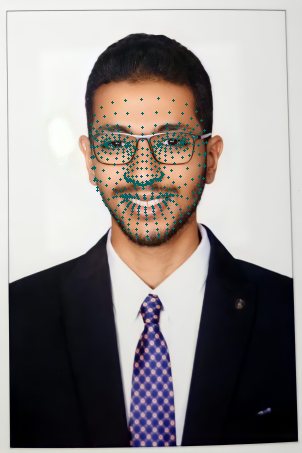


image with the axis



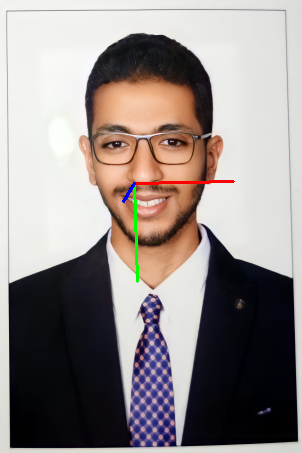

In [10]:
predict_angle_image(image_path)

#Loading video

In [19]:
video_path = "/content/drive/MyDrive/test.mp4"

In [20]:
predict_angle_video_points(video_path)

Number of Detected Frames =  333


In [22]:
predict_angle_video_axis(video_path)

Number of Detected Frames =  333
